In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np

In [73]:
# read csv
df = pd.read_csv('unfiltered_gwq.csv')
# include only state,< district, year
df = df[['state', 'district', 'year', 'chloride']]
# drop duplicates
df = df.drop_duplicates()
# drop rows with missing values
df = df.dropna()
# change indexing
df = df.reset_index(drop=True)
# save df as filtered_gwq.csv
df.to_csv('filtered_gwq.csv', index=False)

In [74]:
df = pd.read_csv('filtered_gwq.csv')
# for filtered_gwq.csv, remove data if state (telangana or andhra pradesh) and year is <= 2004
df = df[~((df['state'] == 'Telangana') & (df['year'] < 2004))]
df = df[~((df['state'] == 'Andhra Pradesh') & (df['year'] < 2004))]
# change indexing
df = df.reset_index(drop=True)
# save df as filtered_gwq.csv
df.to_csv('filtered_gwq.csv', index=False)

                state missing expected  missing_ratio
2       Uttar Pradesh    1003     1387       0.723143
25            Tripura      57       76       0.750000
17              Assam     386      494       0.781377
27          Meghalaya     106      133       0.796992
23  Arunachal Pradesh      94      114       0.824561
26           Nagaland      16       19       0.842105


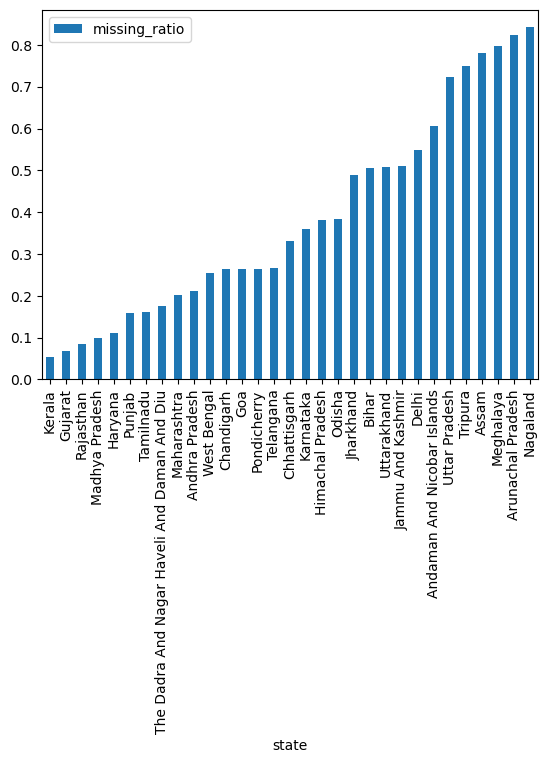

In [77]:
df = pd.read_csv('filtered_gwq.csv')
# Store names of all states
states = df['state'].unique()
# Create a new dataframe to store missing counts (integer)
incomplete_data = pd.DataFrame(columns=['state', 'missing', 'expected', 'missing_ratio'])
# Calculate missing data for each state
for state in states:
    districts = df[df['state'] == state]['district'].unique()
    available = df[df['state'] == state]
    missing_count = 19 * len(districts) - len(available)
    expected_count = 19 * len(districts)
    missing_ratio = 1 - (len(available) / expected_count)
    incomplete_data = pd.concat([incomplete_data, pd.DataFrame({'state': [state], 'missing': [missing_count], 'expected': [expected_count], 'missing_ratio': [missing_ratio]})], ignore_index=True)
incomplete_data = incomplete_data.sort_values('missing_ratio')
incomplete_data.plot(x='state', y='missing_ratio', kind='bar')
# Print states with missing ratio greater than 0.7
print(incomplete_data[incomplete_data['missing_ratio'] > 0.7])

In [ ]:
df1 = pd.read_csv('unfiltered_sdp1.csv')
df2 = pd.read_csv('unfiltered_sdp2.csv')
df3 = pd.read_csv('unfiltered_sdp3.csv')
states = df1.keys()[1:]
df_sdp = pd.DataFrame(columns = df1.keys())
for state in states:
    df1_state = df1[state]
    df2_state = df2[state]
    df3_state = df3[state]
    # scaling factor 1 is df3_state's first value / df2_state's last value
    scaling_factor1 = df3_state.iloc[0] / df2_state.iloc[-1]
    # change df2_state values by scaling factor 1
    df2_state = df2_state * scaling_factor1
    # scaling factor 2 is df2_state's first value / df1_state's last value
    scaling_factor2 = df2_state.iloc[0] / df1_state.iloc[-1]
    # change df1_state values by scaling factor 2
    df1_state = df1_state * scaling_factor2
    
    # remove first and last elements of df2_state
    df2_state = df2_state[1:-1]
    df_sdp[state] = pd.concat([df1_state, df2_state, df3_state], ignore_index=True)
    # print(state, scaling_factor1)
# df_sdp make years as 1999, 2000, and so on
df_sdp['YEAR'] = range(1999, 2019)
df_sdp.to_csv('filtered_sdp.csv', index=False)


In [ ]:
# add sdp for every data in gwq
df_gwq = pd.read_csv('filtered_gwq.csv')
df_sdp = pd.read_csv('filtered_sdp.csv')
n_samples = len(df_gwq)
# for every data in gwq, find the corresponding sdp value
for i in range(n_samples):
    state = df_gwq['state'][i]
    year = df_gwq['year'][i]
    state = state.upper()
    try:
        sdp = df_sdp[state][year - 1999]
        df_gwq.loc[i, 'sdp'] = sdp
    except:
        # print(state)
        # remove data
        df_gwq = df_gwq.drop(i)
# sort by state
df_gwq.dropna()
df_gwq = df_gwq.sort_values('state')
df_gwq.to_csv('filtered_gwq_sdp.csv', index=False)

Q1. SLR

In [80]:
# gwq = beta0 + beta1 * sdp + ui
X = df_gwq['sdp']
X = sm.add_constant(X)
y = df_gwq['chloride']
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
print(model.summary())
r_squared = model.rsquared
print("R-squared:", r_squared)
print(model.params)
# print mean, median, 25th percentile, 75th percentile, and 95th percentile for all variables
print(df_gwq.describe(percentiles=[0.25, 0.5, 0.75, 0.95]))
# calculate errors
predicted_values = model.predict(X)
residuals = y - predicted_values
df_gwq['predicted_chloride'] = predicted_values
df_gwq['residual'] = residuals
df_gwq.to_csv('filtered_gwq_sdp_predicted.csv', index=False)

                            OLS Regression Results                            
Dep. Variable:               chloride   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     68.09
Date:                Sun, 28 Apr 2024   Prob (F-statistic):           1.82e-16
Time:                        23:23:52   Log-Likelihood:                -52452.
No. Observations:                7640   AIC:                         1.049e+05
Df Residuals:                    7638   BIC:                         1.049e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        166.7262      4.284     38.919      0.0

In [81]:
# # plot graph for all states sdp vs year to verify sdp estimations from filtered_sdp.csv
# df_sdp = pd.read_csv('filtered_sdp.csv')
# states = df_sdp.keys()[1:]
# # print(states)
# for state in states:
#     df_sdp.plot(x='YEAR', y=state)
#     plt.show()

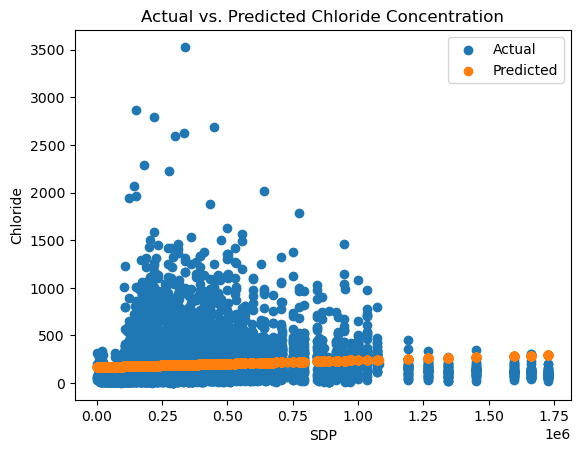

In [82]:
df_gwq = pd.read_csv('filtered_gwq_sdp_predicted.csv')
# Plot 1: Groundwater quality indicator (chloride) on Y-axis and SDP on X-axis
plt.scatter(df_gwq['sdp'], df_gwq['chloride'], label='Actual')
plt.scatter(df_gwq['sdp'], df_gwq['predicted_chloride'], label='Predicted')
plt.xlabel('SDP')
plt.ylabel('Chloride')
plt.title('Actual vs. Predicted Chloride Concentration')

plt.legend()

Q2

/tmp/ipykernel_41155/3679824904.py:13: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  plt.plot([df_gwq['sdp'][i], df_gwq['sdp'][i]], [df_gwq['chloride'][i], df_gwq['predicted_chloride'][i]], 'r-', color='red', lw=0.5)
/tmp/ipykernel_41155/3679824904.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  plt.plot([df_gwq['sdp'][i], df_gwq['sdp'][i]], [df_gwq['chloride'][i], df_gwq['predicted_chloride'][i]], 'r-', color='green', lw=0.5)


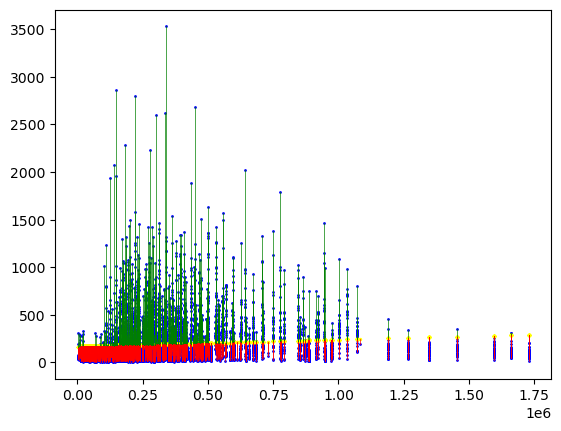

In [83]:
# draw gwq vs sdp graph, and draw lines to connect all actual and predicted values
df_gwq = pd.read_csv('filtered_gwq_sdp_predicted.csv')
n_samples = len(df_gwq)
plt.scatter(df_gwq['sdp'], df_gwq['chloride'], label='Actual', color='blue', s=1)
plt.scatter(df_gwq['sdp'], df_gwq['predicted_chloride'], label='Predicted', color='yellow', s=2)
for i in range(n_samples):
    # plt.plot([df_gwq['sdp'][i], df_gwq['sdp'][i]], [df_gwq['chloride'][i], df_gwq['predicted_chloride'][i]], 'r-', color='black', lw=0.5)
    # for +ve error, use green color
    # for -ve error, use orange color
    if df_gwq['residual'][i] > 0:
        plt.plot([df_gwq['sdp'][i], df_gwq['sdp'][i]], [df_gwq['chloride'][i], df_gwq['predicted_chloride'][i]], 'r-', color='green', lw=0.5)
    elif df_gwq['residual'][i] < 0:
        plt.plot([df_gwq['sdp'][i], df_gwq['sdp'][i]], [df_gwq['chloride'][i], df_gwq['predicted_chloride'][i]], 'r-', color='red', lw=0.5)
plt.show()


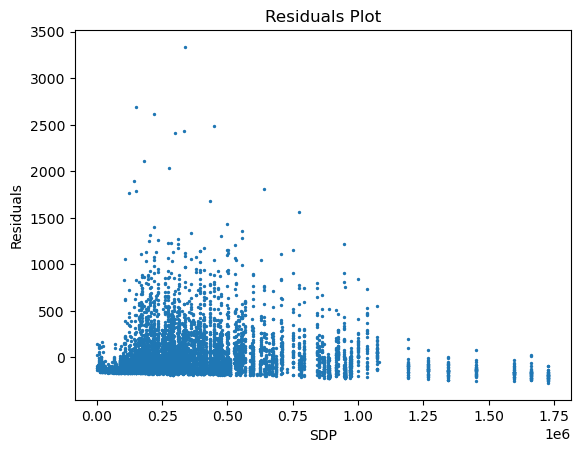

In [84]:
# Plot 2: Residuals (ûi,t) on Y-axis and SDP on X-axis
plt.scatter(df_gwq['sdp'], residuals, s=2)
plt.xlabel('SDP')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.show()

Q3

-2.6338966563344e-09


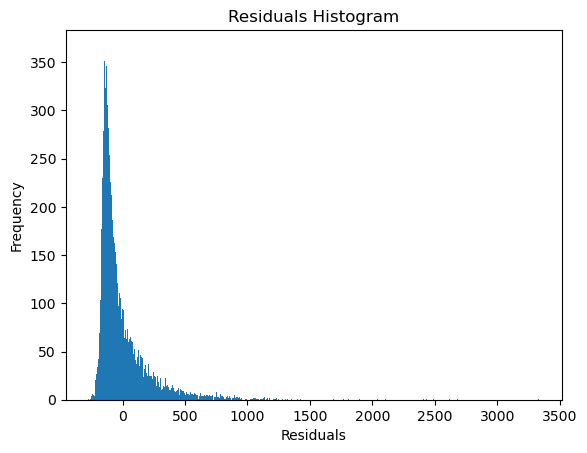

In [85]:
# Plot a histogram of ûi,t and verify that ∑û = 0.
df_gwq = pd.read_csv('filtered_gwq_sdp_predicted.csv')
plt.hist(df_gwq['residual'], bins=500)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Histogram')
# plt.show()
# verify that ∑û = 0
print(df_gwq['residual'].sum())
# print(model.resid.sum())

Q4

In [86]:
# merge gini.csv and filtered_gwq_sdp.csv using district as the common data.
# if district not in gini.csv, print district
# note that districts in gini.csv are capitalized, but not in filtered_gwq_sdp.csv
df_gini = pd.read_csv('gini.csv')
df_gwq = pd.read_csv('filtered_gwq_sdp.csv')
n_samples = len(df_gwq)
for i in range(n_samples):
    district = df_gwq['district'][i]
    district = district.upper()
    if district not in df_gini['district'].values:
        # print(district)
        pass
    else:
        df_gwq.loc[i, 'gini'] = df_gini[df_gini['district'] == district]['gini'].values[0]
df_gwq = df_gwq.dropna()
df_gwq.to_csv('filtered_gwq_sdp_gini.csv', index=False)


                            OLS Regression Results                            
Dep. Variable:               chloride   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     225.4
Date:                Sun, 28 Apr 2024   Prob (F-statistic):           9.73e-96
Time:                        23:23:59   Log-Likelihood:                -50351.
No. Observations:                7367   AIC:                         1.007e+05
Df Residuals:                    7364   BIC:                         1.007e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        5.967e-09   1.29e-10     46.379      

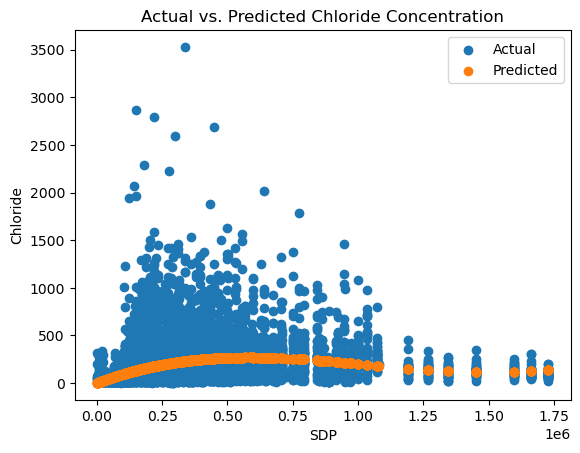

In [87]:
# kuznets with gini
# gwq = b0 + b1sdp + b2sdp^2 + b3sdp^3 + d1GINI + ui,t
df_gwq = pd.read_csv('filtered_gwq_sdp_gini.csv')
# Define the independent variable (predictor) and dependent variable
X = df_gwq[['sdp', 'gini']]
Y = df_gwq['chloride']
# Add a constant to the independent variable for the intercept term
X = sm.add_constant(X)
# Create additional columns for the squared and cubed terms of the predictor
X['sdp_squared'] = X['sdp'] ** 2
X['sdp_cubed'] = X['sdp'] ** 3
# Fit the cubic regression model
model = sm.OLS(Y, X).fit()
# Print the summary of the regression results
print(model.summary())
print(df_gwq.describe(percentiles=[0.25, 0.5, 0.75, 0.95]))
# Get the estimated coefficients
beta0 = model.params['const']
beta1 = model.params['sdp']
beta2 = model.params['sdp_squared']
beta3 = model.params['sdp_cubed']
beta4 = model.params['gini']
# Predicted values
df_gwq['predicted_chloride'] = beta0 + beta1 * df_gwq['sdp'] + beta2 * (df_gwq['sdp'] ** 2) + beta3 * (df_gwq['sdp'] ** 3) + beta4 * df_gwq['gini']
# Calculate residuals
df_gwq['residuals'] = df_gwq['chloride'] - df_gwq['predicted_chloride']
# Calculate R-squared
r_squared = model.rsquared
print("R-squared:", r_squared)
# print estimators
print("Estimated coefficients:")
print("Beta0:", beta0)
print("Beta1:", beta1)
print("Beta2:", beta2)
print("Beta3:", beta3)
print("Beta4:", beta4)
print(df_gwq.describe(percentiles=[0.25, 0.5, 0.75, 0.95]))
# Save the results to a CSV file
df_gwq.to_csv('filtered_gwq_sdp_gini_predicted.csv', index=False)
# plot filtered_gwq_sdp_gini_predicted.csv
df_gwq = pd.read_csv('filtered_gwq_sdp_gini_predicted.csv')
# print sum of residuals
print(df_gwq['residuals'].sum())
# Plot 1: Groundwater quality indicator (chloride) on Y-axis and SDP on X-axis
plt.scatter(df_gwq['sdp'], df_gwq['chloride'], label='Actual')
plt.scatter(df_gwq['sdp'], df_gwq['predicted_chloride'], label='Predicted')
plt.xlabel('SDP')
plt.ylabel('Chloride')
plt.title('Actual vs. Predicted Chloride Concentration')
plt.legend()
plt.show()

135


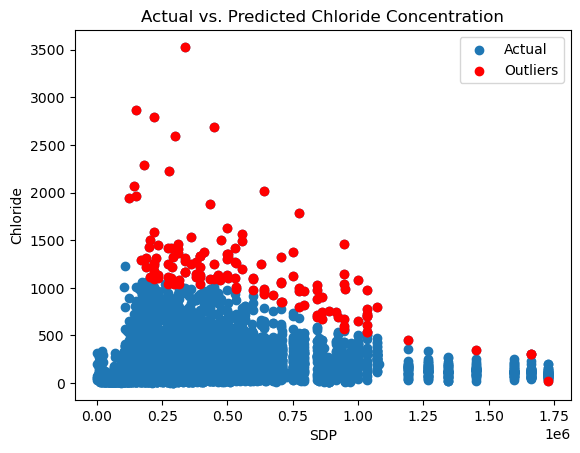

18137.6072643175


In [88]:
# outliers detection: DFFITS
df_gwq = pd.read_csv('filtered_gwq_sdp_gini_predicted.csv')
influence = model.get_influence()
hat_matrix = influence.hat_matrix_diag
residuals = model.resid
# Calculate leverage
leverage = hat_matrix
# Calculate DFFITS
dffits = influence.dffits[0]
# Calculate critical value
n_samples = len(df_gwq)
critical_value = 2 * np.sqrt(5) / np.sqrt( n_samples)
# Print outliers
outliers = df_gwq[np.abs(dffits) > critical_value]
print(len(outliers))
# plot all data points but highlight outliers
plt.scatter(df_gwq['sdp'], df_gwq['chloride'], label='Actual')
plt.scatter(outliers['sdp'], outliers['chloride'], color='red', label='Outliers')
plt.xlabel('SDP')
plt.ylabel('Chloride')
plt.title('Actual vs. Predicted Chloride Concentration')
plt.legend()
plt.show()
# exclude outliers
df_gwq = df_gwq.drop(outliers.index)
# Fit the cubic regression model
model = sm.OLS(Y, X).fit()
print(model.resid.sum())

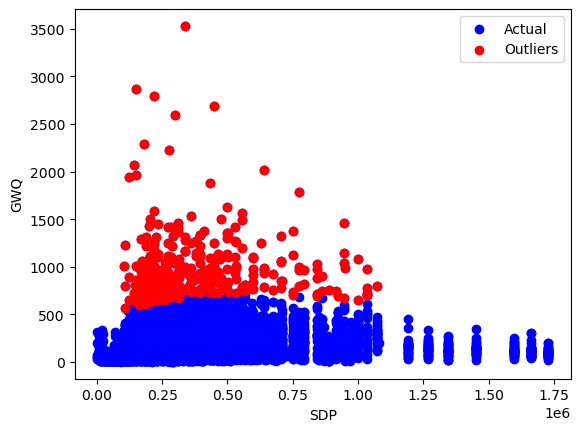

In [89]:
# outliers: rstudent
df_gwq = pd.read_csv('filtered_gwq_sdp_gini_predicted.csv')
rstudent = influence.resid_studentized_internal

# remove outliers with rstudent > 2
outliers = df_gwq[abs(rstudent) > 2]

# plot sdp vs gwq with outliers
plt.scatter(df_gwq['sdp'], df_gwq['chloride'], color='blue', label='Actual')
plt.scatter(outliers['sdp'], outliers['chloride'], color='red', label='Outliers')
plt.xlabel('SDP')
plt.ylabel('GWQ')
plt.legend()
plt.show()

Q6

In [90]:
# Articulate the relationship between economic growth (as measured by SDP) and groundwater quality on year-by-year basis
# (as measured by chloride concentration) in the context of the Kuznets curve.
df_gwq = pd.read_csv('filtered_gwq_sdp_gini_predicted.csv')
# sort by year
df_gwq = df_gwq.sort_values('year')
# redefine model using 19 dummy variables for year
X = df_gwq[['sdp', 'gini']]
Y = df_gwq['chloride']
X = sm.add_constant(X)
X['sdp_squared'] = X['sdp'] ** 2
X['sdp_cubed'] = X['sdp'] ** 3
# Create dummy variables for year
years = df_gwq['year'].unique()
for year in years:
    X['year_' + str(year)] = (df_gwq['year'] == year).astype(int)
# Fit the cubic regression model
model = sm.OLS(Y, X).fit()
# Print the summary of the regression results
print(model.summary())
print(df_gwq.describe(percentiles=[0.25, 0.5, 0.75, 0.95]))

                            OLS Regression Results                            
Dep. Variable:               chloride   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     225.4
Date:                Sun, 28 Apr 2024   Prob (F-statistic):           9.74e-96
Time:                        23:24:12   Log-Likelihood:                -50351.
No. Observations:                7367   AIC:                         1.007e+05
Df Residuals:                    7364   BIC:                         1.007e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        5.964e-09   1.29e-10     46.380      

Q7

In [91]:
# divide region into regions
# Northern: Chandigarh, Delhi, Haryana, Himachal Pradesh, Jammu and Kashmir, Ladakh, Punjab, Rajasthan
# North-Eastern: Arunachal Pradesh, Assam, Manipur, Meghalya, Mizoram, Nagaland, Tripura
# Eastern: Andaman and Nicobar Islands, Bihar, Jharkhand, Odisha, Sikkim, West Bengal
# Central: Chattisgarh, Madhya Pradesh, Uttar Pradesh, Uttarakhand
# Western: Dadra and Nagar Haveli, Daman and Diu, Goa, Gujarat, Maharashtra
# Southern: Andhra Pradesh, Karnataka, Kerala, Tamil Nadu, Telangana, Lakshadweep, Pondicherry
# apply gwq = b0 + b1sdp + b2sdp^2 + b3sdp^3 + d1GINI + ui,t for each region and print the results, also print graph
df_gwq = pd.read_csv('filtered_gwq_sdp_gini.csv')
# Define regions
regions = {
    'Northern': ['Chandigarh', 'Delhi', 'Haryana', 'Himachal Pradesh', 'Jammu and Kashmir', 'Ladakh', 'Punjab', 'Rajasthan'],
    'North-Eastern': ['Arunachal Pradesh', 'Assam', 'Manipur', 'Meghalaya', 'Mizoram', 'Nagaland', 'Tripura'],
    'Eastern': ['Andaman and Nicobar Islands', 'Bihar', 'Jharkhand', 'Odisha', 'Sikkim', 'West Bengal'], 
    'Central': ['Chattisgarh', 'Madhya Pradesh', 'Uttar Pradesh', 'Uttarakhand'],
    'Western': ['Dadra and Nagar Haveli', 'Daman and Diu', 'Goa', 'Gujarat', 'Maharashtra'],
    'Southern': ['Andhra Pradesh', 'Karnataka', 'Kerala', 'Tamil Nadu', 'Telangana', 'Lakshadweep', 'Pondicherry']
}
# Create a new dataframe to store the results
df_results = pd.DataFrame(columns=['Region', 'R-squared', 'Beta0', 'Beta1', 'Beta2', 'Beta3', 'Beta4'])
# Fit the cubic regression model for each region
# introduce a dummy variable for each region
X = df_gwq[['sdp', 'gini']]
Y = df_gwq['chloride']
X = sm.add_constant(X)
X['sdp_squared'] = X['sdp'] ** 2
X['sdp_cubed'] = X['sdp'] ** 3
X['northern'] = df_gwq['state'].isin(regions['Northern']).astype(int)
X['north_eastern'] = df_gwq['state'].isin(regions['North-Eastern']).astype(int)
X['eastern'] = df_gwq['state'].isin(regions['Eastern']).astype(int)
X['central'] = df_gwq['state'].isin(regions['Central']).astype(int)
X['western'] = df_gwq['state'].isin(regions['Western']).astype(int)
X['southern'] = df_gwq['state'].isin(regions['Southern']).astype(int)
model = sm.OLS(Y, X).fit()
# Print the summary of the regression results
print(model.summary())
# Get the estimated coefficients
beta0 = model.params['const']
beta1 = model.params['sdp']
beta2 = model.params['sdp_squared']
beta3 = model.params['sdp_cubed']
beta4 = model.params['gini']
print(df_gwq.describe(percentiles=[0.25, 0.5, 0.75, 0.95]))

                            OLS Regression Results                            
Dep. Variable:               chloride   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     225.4
Date:                Sun, 28 Apr 2024   Prob (F-statistic):           9.73e-96
Time:                        23:24:12   Log-Likelihood:                -50351.
No. Observations:                7367   AIC:                         1.007e+05
Df Residuals:                    7364   BIC:                         1.007e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          5.967e-09   1.29e-10     46.379